In [110]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from statsmodels.graphics.tsaplots import month_plot, quarter_plot 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.model_selection import ParameterGrid 
from prophet import Prophet 
import holidays as hd 
import seaborn as sns 
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


In [111]:
df = pd.read_csv(r"C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Modern Time Series Forecasting Techniques\CAPSTONE PROJECT_ Prophet\DHS_weekly.csv")

In [112]:
df.columns = df.columns.str.lower() 
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.rename(columns={'date':'ds','total individuals in shelter':'y'})

df = df[df['ds'].dt.year != 2021]
df = df.drop(columns=['easter','thanksgiving','christmas'])

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ds           365 non-null    datetime64[ns]
 1   y            365 non-null    int64         
 2   temperature  365 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.4 KB


## Exploratory Data Analysis 

In [114]:
df_temp = df.copy().set_index('ds')
df_temp.index.freq = 'W'

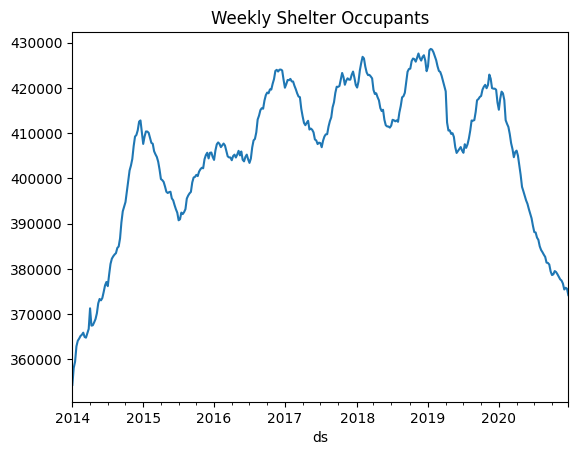

In [115]:
df_temp['y'].plot(title='Weekly Shelter Occupants');

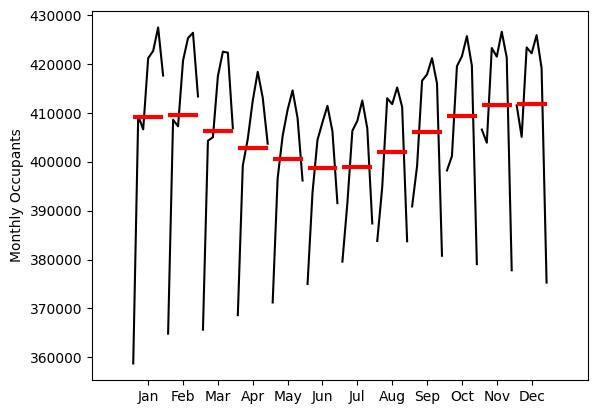

In [116]:
month_plot(df_temp['y'].resample('ME').mean(), ylabel='Monthly Occupants'); 

Insights

The monthly plot of shelter demand in New York City shows the number of occupants from January to December, ranging between 360,000 and 430,000. Key insights:

Seasonal Peaks: Demand spikes in January, March, and August-October, reaching around 420,000, possibly due to colder weather or economic factors.



Low Points: The lowest demand occurs in June and July, dropping to around 360,000, likely due to milder weather reducing shelter needs.



Threshold Line: The red dashed line at 410,000 indicates a critical threshold. Demand exceeds this in January, March, and late summer/fall, suggesting periods of strain on shelter capacity.


Overall Trend: There's a slight downward trend from January to July, followed by a rise in late summer, indicating fluctuating demand throughout the year.
This suggests shelter systems may face pressure during specific months, requiring targeted resource allocation.

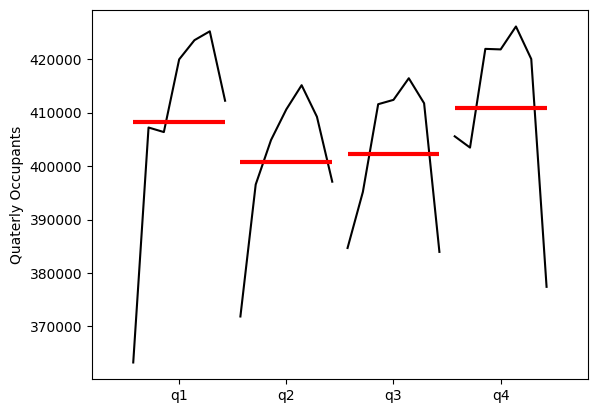

In [117]:
quarter_plot(df_temp['y'].resample('QE').mean(), ylabel='Quaterly Occupants');

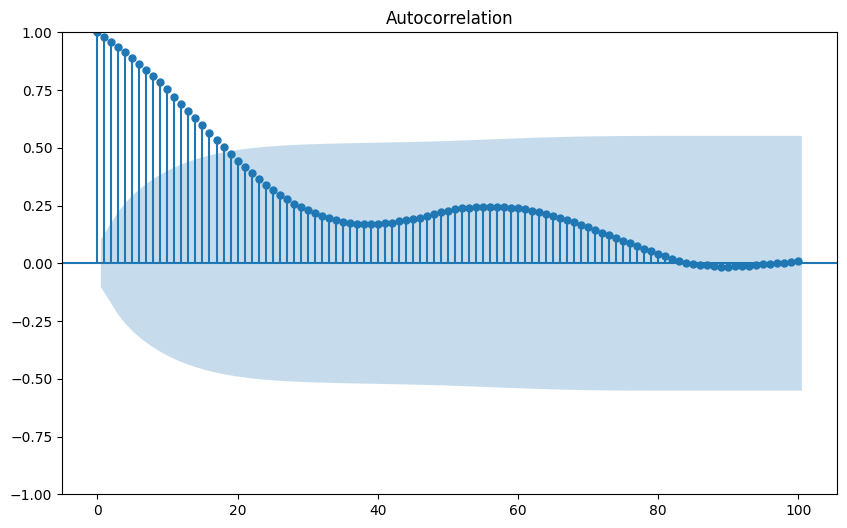

In [118]:
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df_temp['y'],lags=100, ax = ax); 

This autocorrelation plot likely corresponds to the monthly shelter demand data for New York City you shared earlier, as it analyzes the correlation of the time series with itself at different lags (0 to 100). Here’s what the plot reveals:

- **Lag 0 (Perfect Correlation)**: At lag 0, the autocorrelation is 1, as the series is perfectly correlated with itself.
- **Rapid Initial Drop**: The autocorrelation drops sharply from 1 to around 0.2 within the first 10 lags, indicating that the correlation weakens quickly as the time gap increases. This suggests the data has short-term dependencies but not strong long-term trends.
- **Seasonal Pattern**: After the initial drop, the autocorrelation oscillates around 0, with noticeable peaks and troughs roughly every 12 lags (e.g., around lags 12, 24, 36). This periodicity aligns with the monthly nature of the data (12 months in a year), confirming a seasonal pattern in shelter demand, as seen in the earlier plot with peaks in certain months.
- **Confidence Interval**: The shaded area represents the 95% confidence interval (typically around ±0.2 for large samples). Values within this band are not statistically significant. After the first few lags, most autocorrelation values fall within this interval, but the periodic spikes (e.g., at lag 12) slightly exceed it, reinforcing the presence of a significant seasonal effect.
- **Damping Oscillations**: The oscillations gradually dampen as the lag increases, approaching 0 by lag 100, indicating that the seasonal effect weakens over longer time periods.

**Conclusion**: The shelter demand data exhibits a clear seasonal pattern with a 12-month cycle, likely driven by weather or economic factors affecting demand (e.g., higher in winter). However, there’s no strong long-term trend or persistence beyond the seasonal effect, as the autocorrelation diminishes over time. This suggests that forecasting models for shelter demand should account for seasonality, potentially using methods like SARIMA (Seasonal ARIMA).

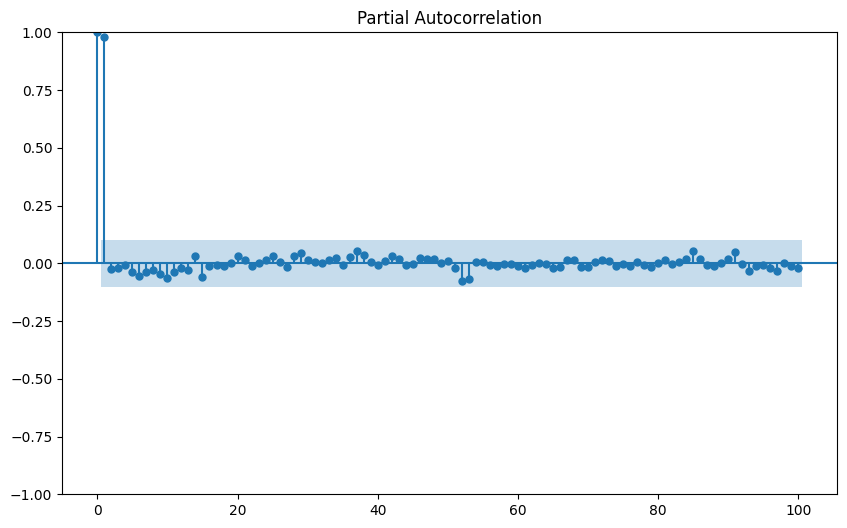

In [119]:
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df_temp['y'],lags=100, ax = ax); 

This partial autocorrelation (PACF) plot likely relates to the monthly shelter demand data for New York City you shared earlier, as it analyzes the direct correlation between the time series and its lagged values after removing the effects of earlier lags. Here’s the interpretation:

- **Lag 0 (Perfect Correlation)**: At lag 0, the partial autocorrelation is 1, as expected, since the series is perfectly correlated with itself.
- **Significant Lag 1**: There’s a sharp drop after lag 0, with lag 1 showing a small but noticeable partial autocorrelation (around 0.1). This suggests that the demand at a given month has a direct correlation with the previous month, even after accounting for earlier lags.
- **No Significant Lags Beyond 1**: After lag 1, the PACF values drop to near 0 and remain within the 95% confidence interval (shaded area, typically around ±0.1 for large samples). This indicates no significant direct correlation at higher lags, meaning the influence of earlier months (beyond the immediate previous month) is negligible once the effect of the first lag is removed.
- **No Seasonal Spikes**: Unlike the autocorrelation plot, which showed a seasonal pattern at lags like 12 and 24, the PACF plot does not show significant spikes at these lags. This suggests that the seasonality observed in the ACF plot is explained by the cumulative effect of earlier lags rather than a direct seasonal correlation.

**Conclusion**: The PACF plot indicates that the shelter demand data has a significant direct dependency only on the immediately preceding month (lag 1). The lack of significant partial autocorrelation at higher lags, including seasonal ones, suggests that an AR(1) model (autoregressive model of order 1) might be sufficient to capture the direct dependencies in the data. However, to fully model the seasonality seen in the ACF plot, a seasonal component (e.g., in a SARIMA model) would still be necessary.

In [120]:
years = range(df["ds"].dt.year.min(), df["ds"].dt.year.max() + 1)

ny_holidays = hd.US(state="NY", years=years)
holidays = pd.DataFrame(ny_holidays.items(), columns=["ds", "holiday"])

holidays['lower_window'] = -1 
holidays['upper_window'] = 1 

## Feature Engineering 

In [121]:
lags = [1, 3, 5, 7]
for lag in lags:
    df[f"temperature_lag_{lag}"] = df["temperature"].shift(lag)


columns = ["y"] + [f"temperature_lag_{lag}" for lag in lags]

<Axes: >

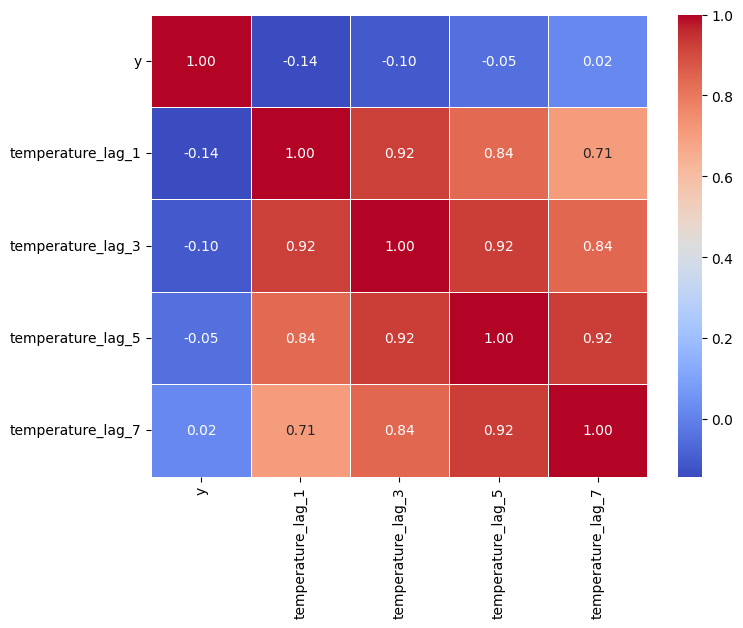

In [122]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    df[columns].corr(), 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5
)

In [123]:
df = df.drop(columns= [f"temperature_lag_{lag}" for lag in [5,7]])

In [124]:
df = df.dropna().reset_index(drop=True) 

In [125]:
max_point = df['ds'].max() 
split_point = max_point - pd.DateOffset(weeks=13) 
split_point

Timestamp('2020-09-27 00:00:00')

In [127]:
df = df.sort_values(by='ds')

In [161]:
test = df[df['ds'] >= split_point].sort_values(by='ds')
train = df[df['ds'] < split_point].sort_values(by='ds')

In [162]:
test.head()

,ds,y,temperature,temperature_lag_1,temperature_lag_3
348,2020-09-27,379435,22.010000,20.405714,25.552857
349,2020-10-04,378631,20.775714,22.010000,24.185714
350,2020-10-11,378796,19.912857,20.775714,20.405714
351,2020-10-18,379521,17.487143,19.912857,22.010000
352,2020-10-25,379293,18.472857,17.487143,20.775714


In [163]:
train.tail()

,ds,y,temperature,temperature_lag_1,temperature_lag_3
343,2020-08-23,383136,25.747143,26.348571,28.535714
344,2020-08-30,382654,27.560000,25.747143,25.970000
345,2020-09-06,381387,25.552857,27.560000,26.348571
346,2020-09-13,381309,24.185714,25.552857,25.747143
347,2020-09-20,380963,20.405714,24.185714,27.560000


In [164]:
model = Prophet(
    holidays=holidays,
    **{
        "changepoint_prior_scale": 0.1,
        "holidays_prior_scale": 1,
        "seasonality_mode": "additive",
        "seasonality_prior_scale": 10,
    }
)

model.add_regressor("temperature")
model.add_regressor("temperature_lag_1")
model.add_regressor("temperature_lag_3")
model.fit(train)

23:19:00 - cmdstanpy - INFO - Chain [1] start processing
23:19:00 - cmdstanpy - INFO - Chain [1] done processing


In [165]:
future_regressors = df.drop(columns=['ds','y']).dropna().reset_index(drop=True) 

future = model.make_future_dataframe(periods=13) 
future = pd.concat([future, future_regressors], axis=1).dropna()
forecast = model.predict(future) 


In [166]:
train.tail()

,ds,y,temperature,temperature_lag_1,temperature_lag_3
343,2020-08-23,383136,25.747143,26.348571,28.535714
344,2020-08-30,382654,27.560000,25.747143,25.970000
345,2020-09-06,381387,25.552857,27.560000,26.348571
346,2020-09-13,381309,24.185714,25.552857,25.747143
347,2020-09-20,380963,20.405714,24.185714,27.560000


In [167]:
test.head()

,ds,y,temperature,temperature_lag_1,temperature_lag_3
348,2020-09-27,379435,22.010000,20.405714,25.552857
349,2020-10-04,378631,20.775714,22.010000,24.185714
350,2020-10-11,378796,19.912857,20.775714,20.405714
351,2020-10-18,379521,17.487143,19.912857,22.010000
352,2020-10-25,379293,18.472857,17.487143,20.775714


23:25:57 - cmdstanpy - INFO - Chain [1] start processing
23:25:57 - cmdstanpy - INFO - Chain [1] done processing


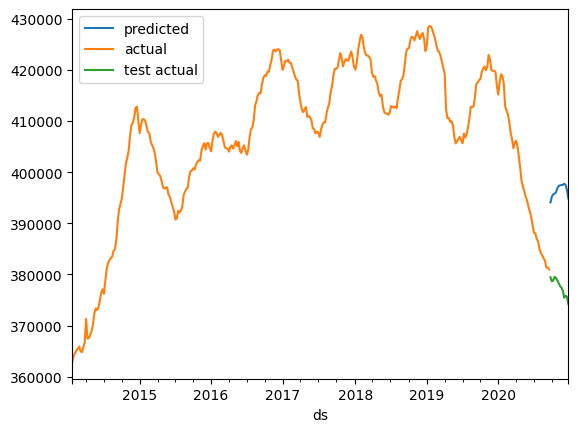

In [177]:
model = Prophet(
    #holidays=holidays, 
    yearly_seasonality=True,
    weekly_seasonality=False, 
    daily_seasonality=False,
    **{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 1,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 10}
)

model.add_regressor("temperature")
# model.add_regressor("temperature_lag_1")
# model.add_regressor("temperature_lag_3")
model.fit(train)



prediction = model.predict(test)
prediction.set_index('ds')['yhat'].plot(label = 'predicted')
train.set_index('ds')['y'].plot(label = 'actual')
test.set_index('ds')['y'].plot(label = 'test actual') 
plt.legend()

In [178]:
np.abs(prediction['yhat'].values - test['y'].values).mean()

np.float64(18880.766236934)

In [179]:
from sklearn.metrics import root_mean_squared_error

In [180]:
root_mean_squared_error(test['y'], prediction['yhat'])

19015.783350635793

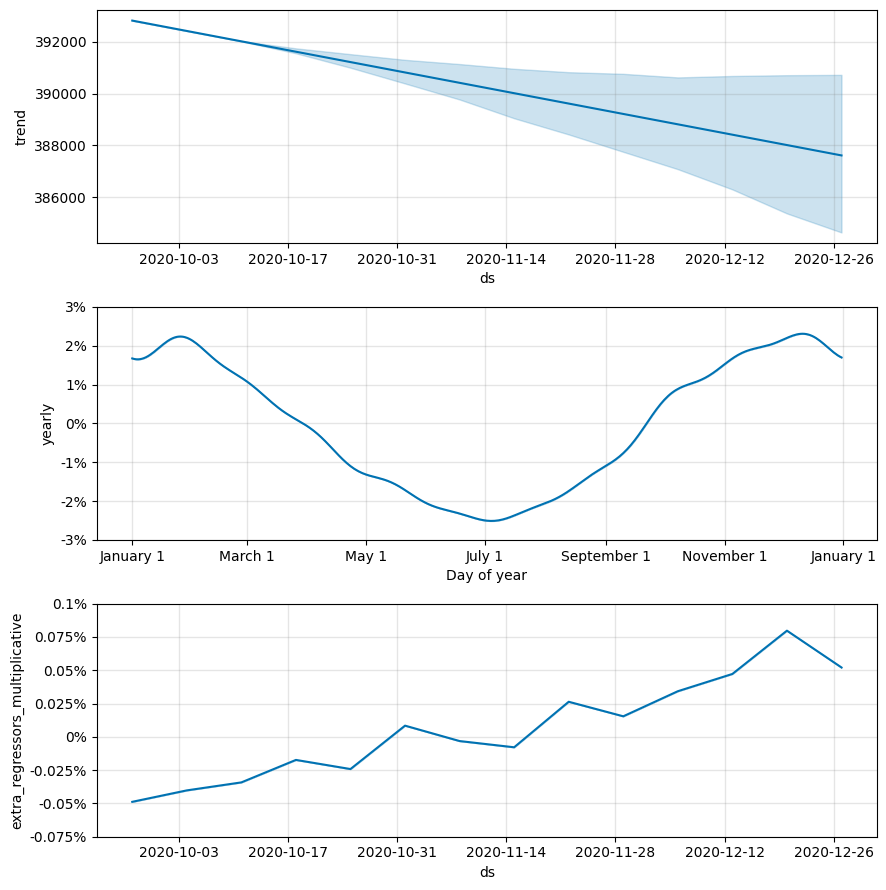

In [181]:
model.plot_components(prediction);

In [148]:
# Define the parameter grid to search
param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1],
    "seasonality_prior_scale": [0.1, 1, 10],
    "holidays_prior_scale":[0.1, 1, 10],
    "seasonality_mode": ["additive", "multiplicative"],
}

In [149]:
all_params = list(ParameterGrid(param_grid))

In [150]:
from tqdm.auto import tqdm

In [ ]:
tuning_results = [] 

for param in tqdm(all_params): 
    model = Prophet(
        holidays=holidays, 
        **param
    )
    model.add_regressor('temperature') 
    model.add_regressor('temperature_lag_1')
    model.add_regressor('temperature_lag_3')
    model.fit(df) 

    df_cv = cross_validation(
        model = model, 
        initial='1500 days', 
        horizon='91 days', 
        period="42 days", 
        parallel='threads'
    )

    rmse = performance_metrics(df_cv)['rmse'].mean() 
    mape = performance_metrics(df_cv)['mape'].mean() 
    mdape = performance_metrics(df_cv)['mdape'].mean() 

    tuning_results.append(
        {
            'rmse': rmse, 
            'mape': mape, 
            'mdape': mdape
        }
    )


In [153]:
tuning_results_df = pd.DataFrame(tuning_results)

In [155]:
best_params = all_params[tuning_results_df['rmse'].idxmin()]